In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import  datasets
import matplotlib.pyplot as plt

In [2]:

class Ordinal(tf.keras.Model):
    def __init__(self,num_classes):
        super(Ordinal,self).__init__(name='')

        omega_init = tf.range(0.,num_classes-1,dtype='float32')
        self.omega = tf.Variable(tf.expand_dims(omega_init,axis=0))
        
        const_zero = tf.zeros((1,1),dtype='float32')
        self.const_zero = tf.constant(const_zero)
        
        b_init = tf.zeros(1,dtype='float32')
        self.b = tf.Variable(b_init)
             
    def call(self,input_X,training=False):

        omega_diff =  tf.nn.relu(self.omega[:,1:]-self.omega[:,:-1]) + 1
        
        theta_pdf = tf.concat([self.const_zero,omega_diff],axis=1)
        
        linear = tf.cumsum(theta_pdf,axis=1) - input_X - self.b*self.b 
        
        cumulative_proba = tf.nn.sigmoid(linear)
        
        proba_list = [cumulative_proba[:,:1],
                      cumulative_proba[:,1:]-cumulative_proba[:,:-1],
                      1-cumulative_proba[:,-1:]]
        proba = tf.keras.layers.Concatenate(axis=1)(proba_list)
        
        return proba
    
    

# Deep Networks

In [3]:
hidden_layers = 32

def create_ordinal_model():
    global hidden_layers
    global num_classes
    model = tf.keras.Sequential([
                            tf.keras.layers.Dense(hidden_layers,activation='relu'),
                            tf.keras.layers.Dense(1,activation='linear'),
                            Ordinal(num_classes)])
    model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy())
    return model

def create_reg_model():
    global hidden_layers
    model = tf.keras.Sequential([
                            tf.keras.layers.Dense(hidden_layers,activation='relu'),
                            tf.keras.layers.Dense(1,activation='linear')])

    model.compile(optimizer = 'adam', loss = tf.keras.losses.MeanAbsoluteError())

    return model

In [4]:
def earthm(data1, data2):
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    data_all = np.sort(np.concatenate([data1, data2]))
    cdf1 = np.searchsorted(data1, data_all, side='right')/(n1)
    cdf2 = np.searchsorted(data2, data_all, side='right')/(n2)
    return np.mean(np.abs(cdf1 - cdf2))

def mae(data1, data2):
    return np.mean(np.abs(data1 - data2))

def acc(data1, data2):
    return np.sum(data1==data2)/data1.shape[0]

def cv_val_preds(X,y):
    
    def get_thetas(omega):
        omega = np.clip(np.diff(omega),0,np.inf)
        theta = np.cumsum(np.concatenate([np.array([0]),omega+1]))
        return theta

    ord_loss = 0
    reg_loss = 0

    actual_test_preds = []
    ord_test_preds = []
    reg_test_preds = []
    thetas = []

    count=0
    simulations = 3
    for _ in range(simulations):

        kfold = model_selection.StratifiedKFold(5,shuffle=True)

        for train,test in kfold.split(X,y):
            print(f'fold{count}')

            #regression model
            tf.keras.backend.clear_session()

            es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20,
                                     verbose=0, mode='min', baseline=None, restore_best_weights=True)


            reg_model = create_reg_model()

            reg_model.fit(X[train], y[train], validation_data=(X[test], y[test]), callbacks=[es],
                      epochs = 1000, batch_size = 10,verbose=0)

            reg_y_pred = np.clip(np.round(reg_model.predict(X[test]).flatten(),0),0,num_classes-1)

            reg_loss += np.mean(np.abs(reg_y_pred-y[test]))

            print('deep regression MAE',reg_loss)

            #ordinal model
            ord_model = create_ordinal_model()
            ord_model.fit(X[train], y[train], validation_data=(X[test], y[test]), callbacks=[es],
                      epochs = 1000, batch_size = 10,verbose=0)

            ord_y_pred = np.argmax(ord_model.predict(X[test]),axis=1)

            ord_loss += np.mean(np.abs(ord_y_pred-y[test]))

            print('deep ordinal MAE',ord_loss)

            thetas.append(get_thetas(ord_model.layers[2].omega.numpy().flatten()))
            actual_test_preds.append(y[test])
            ord_test_preds.append(ord_y_pred)
            reg_test_preds.append(reg_y_pred)
            count+=1
        print()

    reg_test_preds = np.concatenate(reg_test_preds,axis=0)
    actual_test_preds = np.concatenate(actual_test_preds,axis=0)
    ord_test_preds = np.concatenate(ord_test_preds,axis=0)
    
    return actual_test_preds,reg_test_preds,ord_test_preds,thetas

# Load Data

In [5]:
house = pd.read_csv('data/bostonhousing_ord.csv')
stock = pd.read_csv('data/stock_ord.csv')
kinematics = pd.read_csv('data/kinematics.csv')

# Boston Housing Dataset 

In [6]:
y = house[['response']].values
X = house[['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13']].values


standardizer = preprocessing.StandardScaler()
X = standardizer.fit_transform(X)

y -= y.min()
y = y.flatten()

num_inputs = X.shape[1]
num_classes = len(np.unique(y))

# Cross Validation Y True/Pred

In [7]:
actual_test_preds,reg_test_preds,ord_test_preds,thetas = cv_val_preds(X,y)

fold0
deep regression MAE 0.29411764705882354
deep ordinal MAE 0.23529411764705882
fold1
deep regression MAE 0.551543389633081
deep ordinal MAE 0.5224228305183459
fold2
deep regression MAE 0.8386721025043682
deep ordinal MAE 0.7996505532906232
fold3
deep regression MAE 1.1258008153756554
deep ordinal MAE 1.0768782760629003
fold4
deep regression MAE 1.3832265579499128
deep ordinal MAE 1.2847990681421082

fold5
deep regression MAE 1.6969520481459912
deep ordinal MAE 1.5789167152009318
fold6
deep regression MAE 2.013783731314308
deep ordinal MAE 1.8858474082702388
fold7
deep regression MAE 2.1920015530964863
deep ordinal MAE 2.0838672102504368
fold8
deep regression MAE 2.459328285769754
deep ordinal MAE 2.341292952824694
fold9
deep regression MAE 2.7464569986410408
deep ordinal MAE 2.5987186953989516

fold10
deep regression MAE 3.0601824888371194
deep ordinal MAE 2.87322849932052
fold11
deep regression MAE 3.396816152203456
deep ordinal MAE 3.100951271597748
fold12
deep regression MAE 3.6

In [8]:
print('regression MAE',mae(reg_test_preds,actual_test_preds))

print('ordinal MAE',mae(ord_test_preds,actual_test_preds))

regression MAE 0.27865612648221344
ordinal MAE 0.25757575757575757


In [9]:
print('regression EMD',earthm(reg_test_preds,actual_test_preds))

print('ordinal EMD',earthm(ord_test_preds,actual_test_preds))

regression EMD 0.017935845827236157
ordinal EMD 0.015341375605166685


In [10]:
print('regression accuracy',acc(reg_test_preds,actual_test_preds.flatten()))

print('ordinal accuracy',acc(ord_test_preds,actual_test_preds.flatten()))

regression accuracy 0.7371541501976284
ordinal accuracy 0.7516469038208169


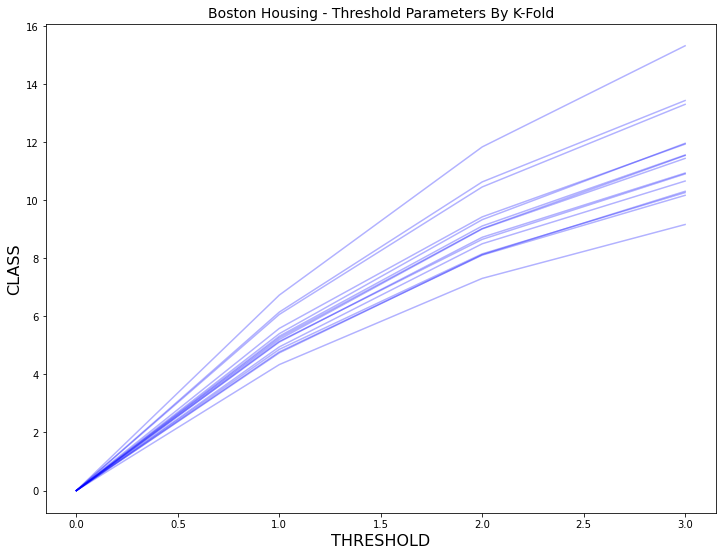

In [11]:
plt.figure(figsize=(12,9))
plt.plot(np.column_stack(thetas),'b-',alpha=0.3)
plt.title('Boston Housing - Threshold Parameters By K-Fold',fontsize=14)
plt.xlabel('THRESHOLD',fontsize=16)
plt.ylabel('CLASS',fontsize=16)
plt.show()

In [12]:
ct = pd.crosstab(actual_test_preds,reg_test_preds)
ct.index.name = 'actual'
ct.columns.name = 'regression'
ct

regression,0.0,1.0,2.0,3.0,4.0
actual,,,,,
0,146,85,0,0,0
1,32,604,78,0,3
2,2,105,218,44,0
3,0,0,16,87,5
4,0,3,10,16,64


In [13]:
ct = pd.crosstab(actual_test_preds,ord_test_preds)
ct.index.name = 'actual'
ct.columns.name = 'ordinal'
ct

ordinal,0,1,2,3,4
actual,,,,,
0,164,67,0,0,0
1,46,598,70,0,3
2,1,112,230,24,2
3,0,0,27,71,10
4,0,0,5,10,78


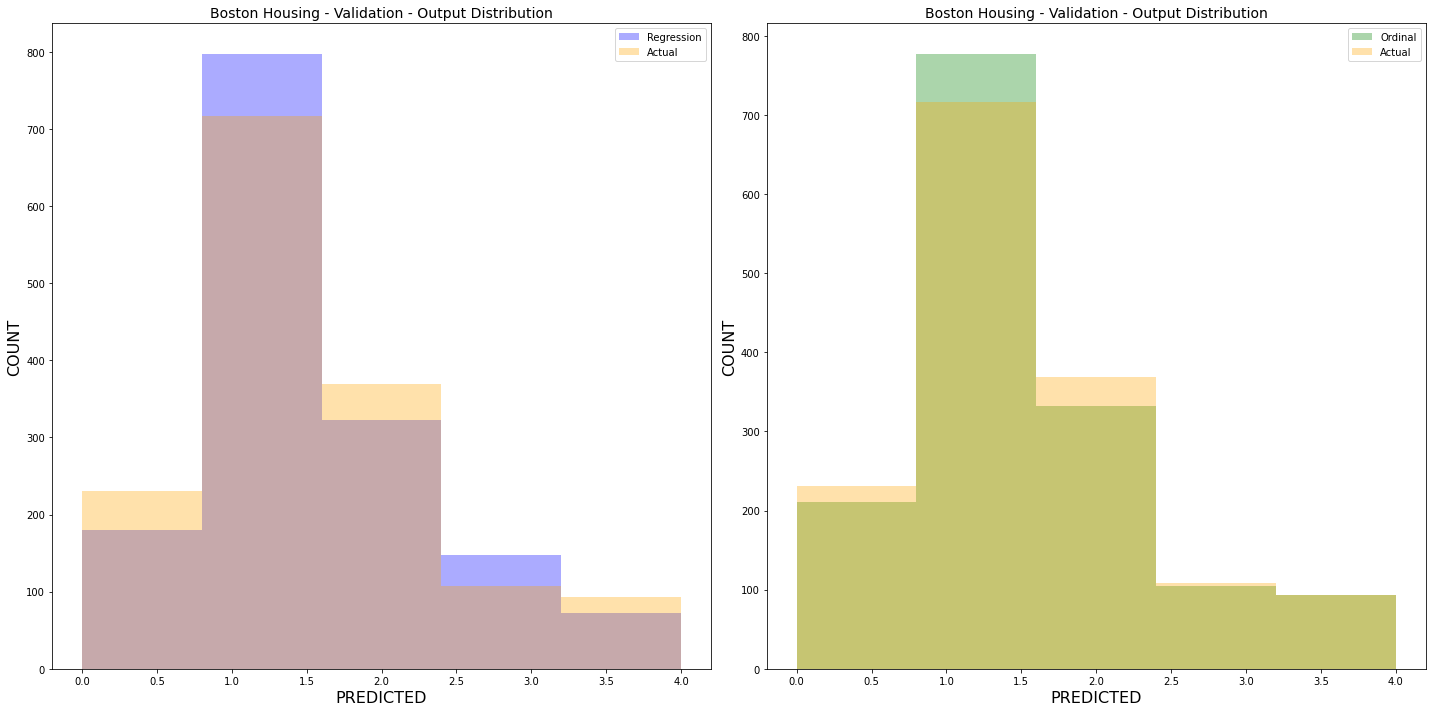

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(121)

plt.hist(reg_test_preds,bins=num_classes,alpha=0.33,label='Regression',color='blue')

plt.hist(actual_test_preds,bins=num_classes,alpha=0.33,label='Actual',color='orange')

plt.title('Boston Housing - Validation - Output Distribution',fontsize=14)
plt.xlabel('PREDICTED',fontsize=16)
plt.ylabel('COUNT',fontsize=16)
plt.legend()

plt.subplot(122)

plt.hist(ord_test_preds,bins=num_classes,alpha=0.33,label='Ordinal',color='green')

plt.hist(actual_test_preds,bins=num_classes,alpha=0.33,label='Actual',color='orange')

plt.title('Boston Housing - Validation - Output Distribution',fontsize=14)
plt.xlabel('PREDICTED',fontsize=16)
plt.ylabel('COUNT',fontsize=16)
plt.legend()
plt.tight_layout()

In [15]:
y = stock[['response']].values
X = stock[['V1','V2','V3','V4','V5','V6','V7','V8','V9']].values

standardizer = preprocessing.StandardScaler()
X = standardizer.fit_transform(X)

y -= y.min()
y = y.flatten()

num_inputs = X.shape[1]
num_classes = len(np.unique(y))

In [16]:
actual_test_preds,reg_test_preds,ord_test_preds,thetas = cv_val_preds(X,y)

fold0
deep regression MAE 0.12105263157894737
deep ordinal MAE 0.08421052631578947
fold1
deep regression MAE 0.2736842105263158
deep ordinal MAE 0.2210526315789474
fold2
deep regression MAE 0.4
deep ordinal MAE 0.3526315789473684
fold3
deep regression MAE 0.5368421052631579
deep ordinal MAE 0.4842105263157894
fold4
deep regression MAE 0.7210526315789474
deep ordinal MAE 0.6105263157894736

fold5
deep regression MAE 0.8473684210526315
deep ordinal MAE 0.7157894736842104
fold6
deep regression MAE 1.0157894736842106
deep ordinal MAE 0.8736842105263156
fold7
deep regression MAE 1.168421052631579
deep ordinal MAE 0.963157894736842
fold8
deep regression MAE 1.3157894736842106
deep ordinal MAE 1.0736842105263156
fold9
deep regression MAE 1.4631578947368422
deep ordinal MAE 1.1947368421052629

fold10
deep regression MAE 1.5789473684210527
deep ordinal MAE 1.3157894736842102
fold11
deep regression MAE 1.7473684210526317
deep ordinal MAE 1.4473684210526312
fold12
deep regression MAE 1.8789473684

In [17]:
print('regression MAE',mae(reg_test_preds,actual_test_preds))

print('ordinal MAE',mae(ord_test_preds,actual_test_preds))

regression MAE 0.14280701754385966
ordinal MAE 0.11894736842105263


In [18]:
print('regression EMD',earthm(reg_test_preds,actual_test_preds))

print('ordinal EMD',earthm(ord_test_preds,actual_test_preds))

regression EMD 0.008815327793167127
ordinal EMD 0.004359556786703612


In [19]:
print('regression accuracy',acc(reg_test_preds,actual_test_preds.flatten()))

print('ordinal accuracy',acc(ord_test_preds,actual_test_preds.flatten()))

regression accuracy 0.8571929824561404
ordinal accuracy 0.8810526315789474


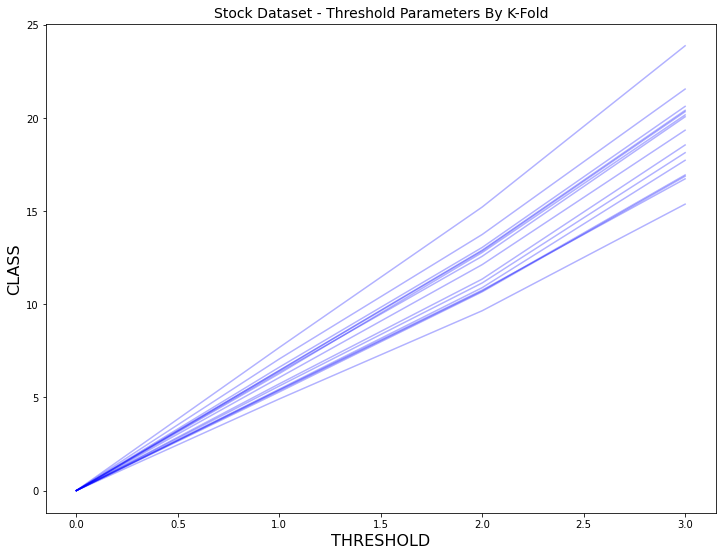

In [20]:
plt.figure(figsize=(12,9))
plt.plot(np.column_stack(thetas),'b-',alpha=0.3)
plt.title('Stock Dataset - Threshold Parameters By K-Fold',fontsize=14)
plt.xlabel('THRESHOLD',fontsize=16)
plt.ylabel('CLASS',fontsize=16)
plt.show()

In [21]:
ct = pd.crosstab(actual_test_preds,reg_test_preds)
ct.index.name = 'actual'
ct.columns.name = 'regression'
ct

regression,0.0,1.0,2.0,3.0,4.0
actual,,,,,
0,445,29,0,0,0
1,65,480,136,0,0
2,0,56,721,39,0
3,0,0,43,558,20
4,0,0,0,19,239


In [22]:
ct = pd.crosstab(actual_test_preds,ord_test_preds)
ct.index.name = 'actual'
ct.columns.name = 'ordinal'
ct

ordinal,0,1,2,3,4
actual,,,,,
0,452,22,0,0,0
1,54,544,83,0,0
2,0,62,713,41,0
3,0,0,36,563,22
4,0,0,0,19,239


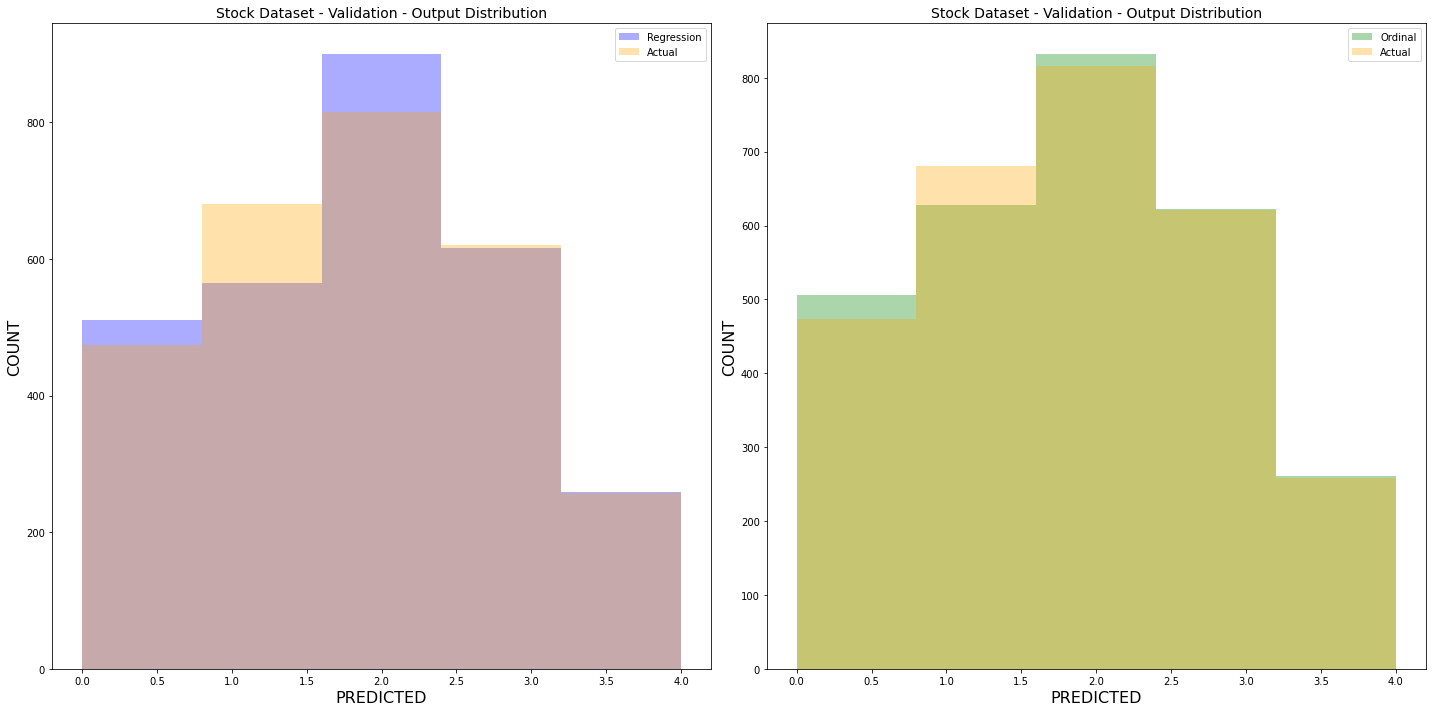

In [23]:
plt.figure(figsize=(20,10))

plt.subplot(121)

plt.hist(reg_test_preds,bins=num_classes,alpha=0.33,label='Regression',color='blue')

plt.hist(actual_test_preds,bins=num_classes,alpha=0.33,label='Actual',color='orange')

plt.title('Stock Dataset - Validation - Output Distribution',fontsize=14)
plt.xlabel('PREDICTED',fontsize=16)
plt.ylabel('COUNT',fontsize=16)
plt.legend()

plt.subplot(122)

plt.hist(ord_test_preds,bins=num_classes,alpha=0.33,label='Ordinal',color='green')

plt.hist(actual_test_preds,bins=num_classes,alpha=0.33,label='Actual',color='orange')

plt.title('Stock Dataset - Validation - Output Distribution',fontsize=14)
plt.xlabel('PREDICTED',fontsize=16)
plt.ylabel('COUNT',fontsize=16)
plt.legend()
plt.tight_layout()

In [24]:
y = kinematics[['response']].values
X = kinematics[['X1','X2','X3','X4','X5','X6','X7','X8']].values

standardizer = preprocessing.StandardScaler()
X = standardizer.fit_transform(X)

y -= y.min()
y = y.flatten()

num_inputs = X.shape[1]
num_classes = len(np.unique(y))


In [25]:
actual_test_preds,reg_test_preds,ord_test_preds,thetas = cv_val_preds(X,y)

fold0
deep regression MAE 0.5723001830384381
deep ordinal MAE 0.5320317266625991
fold1
deep regression MAE 1.136058572300183
deep ordinal MAE 1.0658938377059182
fold2
deep regression MAE 1.7422856785272893
deep ordinal MAE 1.6361014079134883
fold3
deep regression MAE 2.330808267049878
deep ordinal MAE 2.1721209439330242
fold4
deep regression MAE 2.904678840920452
deep ordinal MAE 2.7191294909415715

fold5
deep regression MAE 3.4989436365275295
deep ordinal MAE 3.2676346770306504
fold6
deep regression MAE 4.064532410169995
deep ordinal MAE 3.817970247500449
fold7
deep regression MAE 4.60970945534704
deep ordinal MAE 4.321633251163453
fold8
deep regression MAE 5.186632532270116
deep ordinal MAE 4.849716279246481
fold9
deep regression MAE 5.784923130560714
deep ordinal MAE 5.4205343500645515

fold10
deep regression MAE 6.332818188522887
deep ordinal MAE 5.964768639265284
fold11
deep regression MAE 6.8923056808962855
deep ordinal MAE 6.510833312846736
fold12
deep regression MAE 7.475944264

In [26]:
print('regression MAE',mae(reg_test_preds,actual_test_preds))

print('ordinal MAE',mae(ord_test_preds,actual_test_preds))

regression MAE 0.5751139322916666
ordinal MAE 0.53857421875


In [27]:
print('regression EMD',earthm(reg_test_preds,actual_test_preds))

print('ordinal EMD',earthm(ord_test_preds,actual_test_preds))

regression EMD 0.0208123591211107
ordinal EMD 0.001886031693882426


In [28]:
print('regression accuracy',acc(reg_test_preds,actual_test_preds.flatten()))

print('ordinal accuracy',acc(ord_test_preds,actual_test_preds.flatten()))

regression accuracy 0.5074869791666666
ordinal accuracy 0.5348307291666666


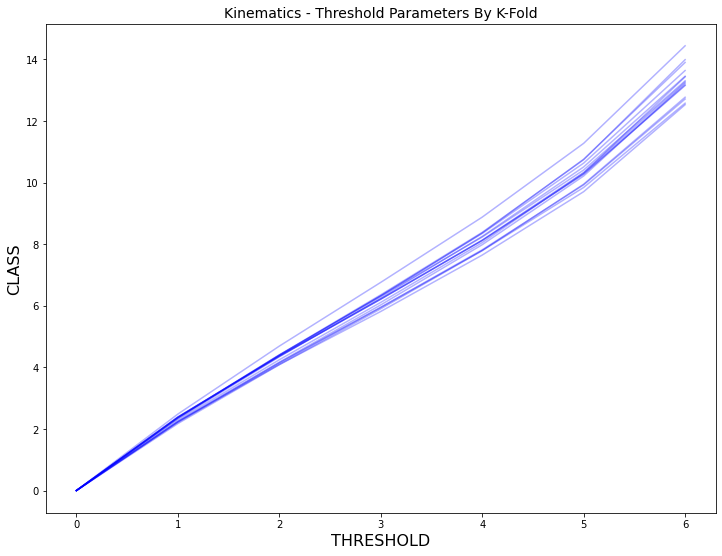

In [29]:
plt.figure(figsize=(12,9))
plt.plot(np.column_stack(thetas),'b-',alpha=0.3)
plt.title('Kinematics - Threshold Parameters By K-Fold',fontsize=14)
plt.xlabel('THRESHOLD',fontsize=16)
plt.ylabel('CLASS',fontsize=16)
plt.show()

In [30]:
pd.crosstab(actual_test_preds,reg_test_preds)

col_0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
row_0,,,,,,,,
0,1666,1160,221,21,4,0,0,0
1,455,1373,982,233,29,0,0,0
2,130,492,1380,880,163,25,2,0
3,18,75,671,1435,770,101,2,0
4,0,14,140,821,1432,601,62,2
5,0,1,26,193,840,1568,421,23
6,1,1,3,23,175,993,1572,304
7,0,0,0,4,15,113,894,2046


In [31]:
pd.crosstab(actual_test_preds,ord_test_preds)

col_0,0,1,2,3,4,5,6,7
row_0,,,,,,,,
0,2138,791,128,14,1,0,0,0
1,700,1411,784,166,10,1,0,0
2,180,674,1282,708,201,26,1,0
3,25,115,740,1307,758,123,4,0
4,2,17,148,770,1299,732,102,2
5,0,1,22,149,721,1451,704,24
6,1,2,3,9,112,673,1817,455
7,0,0,0,0,4,50,579,2439


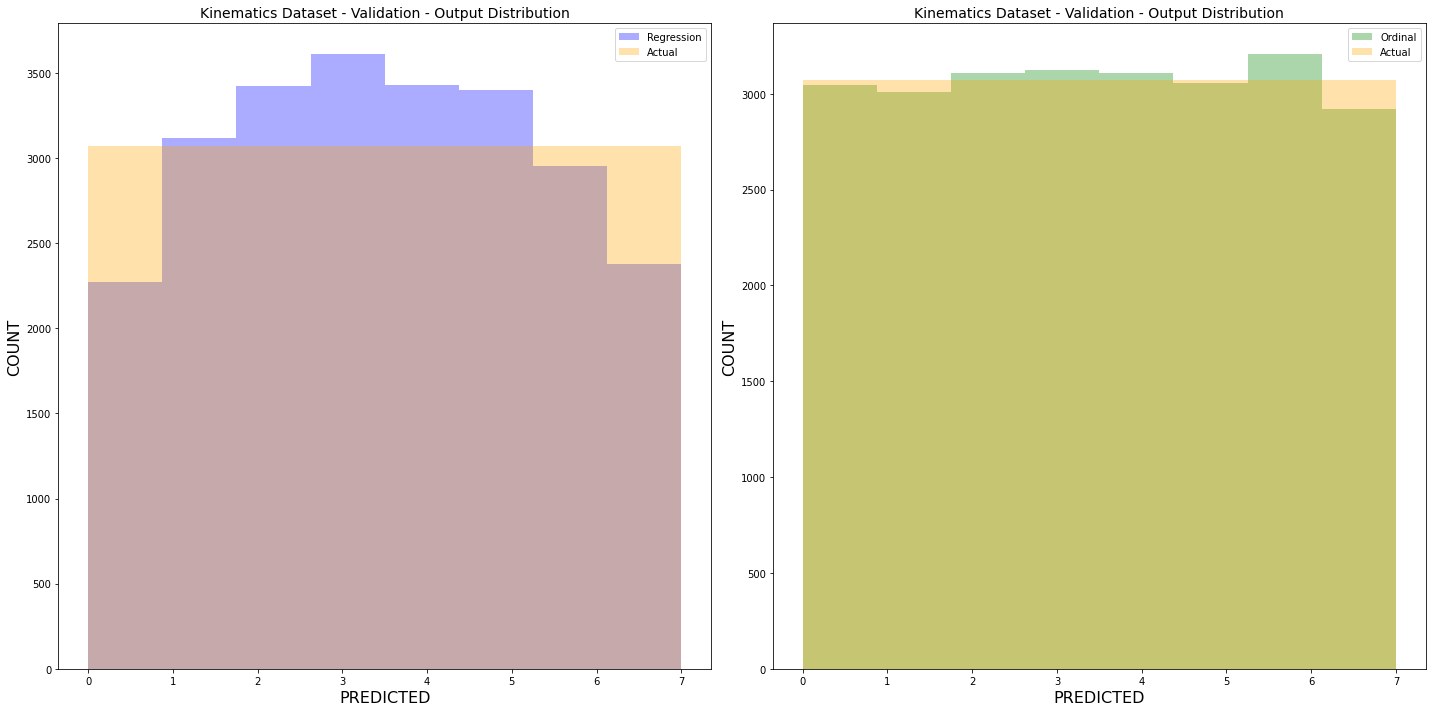

In [32]:
plt.figure(figsize=(20,10))

plt.subplot(121)

plt.hist(reg_test_preds,bins=num_classes,alpha=0.33,label='Regression',color='blue')

plt.hist(actual_test_preds,bins=num_classes,alpha=0.33,label='Actual',color='orange')

plt.title('Kinematics Dataset - Validation - Output Distribution',fontsize=14)
plt.xlabel('PREDICTED',fontsize=16)
plt.ylabel('COUNT',fontsize=16)
plt.legend()

plt.subplot(122)

plt.hist(ord_test_preds,bins=num_classes,alpha=0.33,label='Ordinal',color='green')

plt.hist(actual_test_preds,bins=num_classes,alpha=0.33,label='Actual',color='orange')

plt.title('Kinematics Dataset - Validation - Output Distribution',fontsize=14)
plt.xlabel('PREDICTED',fontsize=16)
plt.ylabel('COUNT',fontsize=16)
plt.legend()
plt.tight_layout()